# Confusion Matrix Analysis

Analyze which PII labels get confused with each other.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gliner import GLiNER
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

/opt/homebrew/Caskroom/miniconda/base/envs/ab_312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Gold Dataset (50 samples for quick test)

In [2]:
# Load samples from gold dataset
samples = []
with open('../../Data/gold_testdataset_27labels.ndjson', 'r') as f:
    for i, line in enumerate(f):
        if i >= 50:  # Only 50 samples
            break
        line = line.strip()
        if line.endswith(','):
            line = line[:-1]
        samples.append(json.loads(line))

print(f"Loaded {len(samples)} samples")

Loaded 50 samples


## Load Model

In [3]:
# Load finetuned model
model = GLiNER.from_pretrained("../../finetuned_gliner")
print("Model loaded")

Model loaded


## Define Labels

In [4]:
# Labels the model can detect
labels = [
    "date", "social security number", "tax identification number",
    "drivers license number", "identity card number", "passport number", 
    "full name", "phone number", "mobile phone number", "address", 
    "email address", "ip address", "fax number", "credit card number", 
    "credit score", "bank account number", "bank account balance", "iban",
    "health insurance id number", "insurance plan number", 
    "national health insurance number", "medical condition", "medication",
    "birth certificate number", "medical treatment", "student id number",
    "username", "organization"
]

print(f"Using {len(labels)} labels")

Using 28 labels


## Run Predictions and Collect Results

In [5]:
# Collect all true and predicted labels
true_labels = []
pred_labels = []

for sample in tqdm(samples, desc="Processing"):
    text = sample['text']
    ground_truth = sample['normalized_entities']
    
    # Get predictions
    predictions = model.predict_entities(text, labels, threshold=0.3)
    
    # Create a mapping of text spans to labels
    gt_dict = {(ent['text'].lower().strip(), ent['start'], ent['end']): ent['label'] 
               for ent in ground_truth}
    
    pred_dict = {(pred['text'].lower().strip(), pred['start'], pred['end']): pred['label'] 
                 for pred in predictions}
    
    # For each ground truth entity
    for key, true_label in gt_dict.items():
        if key in pred_dict:
            # Model found this entity
            true_labels.append(true_label)
            pred_labels.append(pred_dict[key])
        else:
            # Model missed this entity
            true_labels.append(true_label)
            pred_labels.append('MISSED')
    
    # For predictions not in ground truth (false positives)
    for key, pred_label in pred_dict.items():
        if key not in gt_dict:
            true_labels.append('NO_ENTITY')
            pred_labels.append(pred_label)

print(f"\nCollected {len(true_labels)} entity comparisons")

Processing:  44%|████▍     | 22/50 [00:03<00:04,  6.26it/s]/opt/homebrew/Caskroom/miniconda/base/envs/ab_312/lib/python3.12/site-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 524 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
Processing: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


Collected 259 entity comparisons


## Get Most Common Labels

In [6]:
# Get top N most common labels for cleaner visualization
from collections import Counter

label_counts = Counter(true_labels)
top_labels = [label for label, count in label_counts.most_common(15) if label != 'NO_ENTITY']

print(f"Top {len(top_labels)} most common labels:")
for label in top_labels:
    print(f"  - {label}: {label_counts[label]} occurrences")

Top 14 most common labels:
  - date: 39 occurrences
  - full name: 27 occurrences
  - organization: 11 occurrences
  - email address: 11 occurrences
  - bank account number: 11 occurrences
  - social security number: 9 occurrences
  - username: 8 occurrences
  - phone number: 8 occurrences
  - credit card number: 7 occurrences
  - tax identification number: 6 occurrences
  - address: 6 occurrences
  - health insurance id number: 6 occurrences
  - iban: 5 occurrences
  - fax number: 4 occurrences


## Create Confusion Matrix

In [7]:
# Filter to only include top labels
filtered_true = []
filtered_pred = []

for true, pred in zip(true_labels, pred_labels):
    if true in top_labels:
        filtered_true.append(true)
        if pred in top_labels:
            filtered_pred.append(pred)
        else:
            filtered_pred.append('OTHER')

# Add 'OTHER' to labels if needed
if 'OTHER' in filtered_pred:
    display_labels = top_labels + ['OTHER']
else:
    display_labels = top_labels

# Create confusion matrix
cm = confusion_matrix(filtered_true, filtered_pred, labels=display_labels)

print(f"Confusion matrix shape: {cm.shape}")

Confusion matrix shape: (15, 15)


## Visualize Confusion Matrix

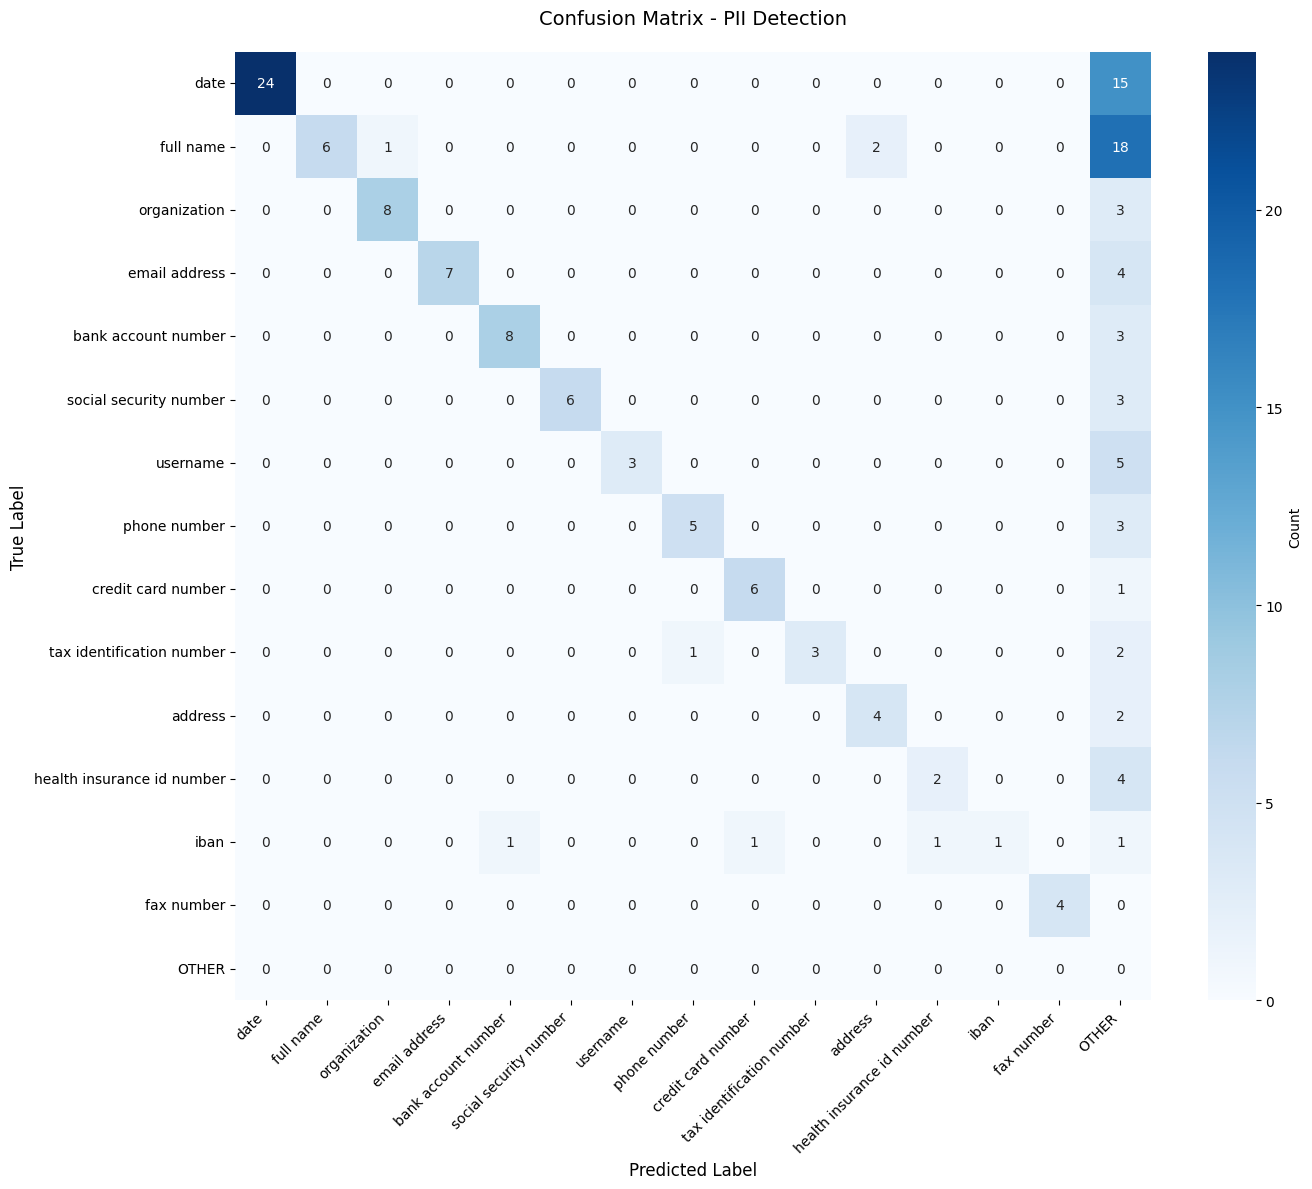

In [8]:
# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=display_labels, 
            yticklabels=display_labels,
            cbar_kws={'label': 'Count'})

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - PII Detection', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Analyze Most Confused Pairs

In [9]:
# Find most confused pairs (excluding diagonal)
confused_pairs = []

for i, true_label in enumerate(display_labels):
    for j, pred_label in enumerate(display_labels):
        if i != j and cm[i, j] > 0:  # Skip diagonal (correct predictions)
            confused_pairs.append({
                'True Label': true_label,
                'Predicted As': pred_label,
                'Count': cm[i, j]
            })

# Sort by count
confused_df = pd.DataFrame(confused_pairs).sort_values('Count', ascending=False)

print("\nTop 10 Most Confused Label Pairs:")
print("=" * 70)
confused_df.head(10)


Top 10 Most Confused Label Pairs:


,True Label,Predicted As,Count
3,full name,OTHER,18
0,date,OTHER,15
8,username,OTHER,5
14,health insurance id number,OTHER,4
5,email address,OTHER,4
7,social security number,OTHER,3
9,phone number,OTHER,3
6,bank account number,OTHER,3
4,organization,OTHER,3
12,tax identification number,OTHER,2


## Per-Label Accuracy

In [10]:
# Calculate per-label accuracy
per_label_accuracy = []

for i, label in enumerate(display_labels):
    if label == 'OTHER':
        continue
    total = cm[i, :].sum()
    correct = cm[i, i]
    accuracy = (correct / total * 100) if total > 0 else 0
    
    per_label_accuracy.append({
        'Label': label,
        'Total': total,
        'Correct': correct,
        'Accuracy': accuracy
    })

accuracy_df = pd.DataFrame(per_label_accuracy).sort_values('Accuracy', ascending=False)

print("\nPer-Label Accuracy:")
print("=" * 70)
accuracy_df


Per-Label Accuracy:


,Label,Total,Correct,Accuracy
13,fax number,4,4,100.000000
8,credit card number,7,6,85.714286
2,organization,11,8,72.727273
4,bank account number,11,8,72.727273
5,social security number,9,6,66.666667
10,address,6,4,66.666667
3,email address,11,7,63.636364
7,phone number,8,5,62.500000
0,date,39,24,61.538462
9,tax identification number,6,3,50.000000


## Visualize Per-Label Accuracy

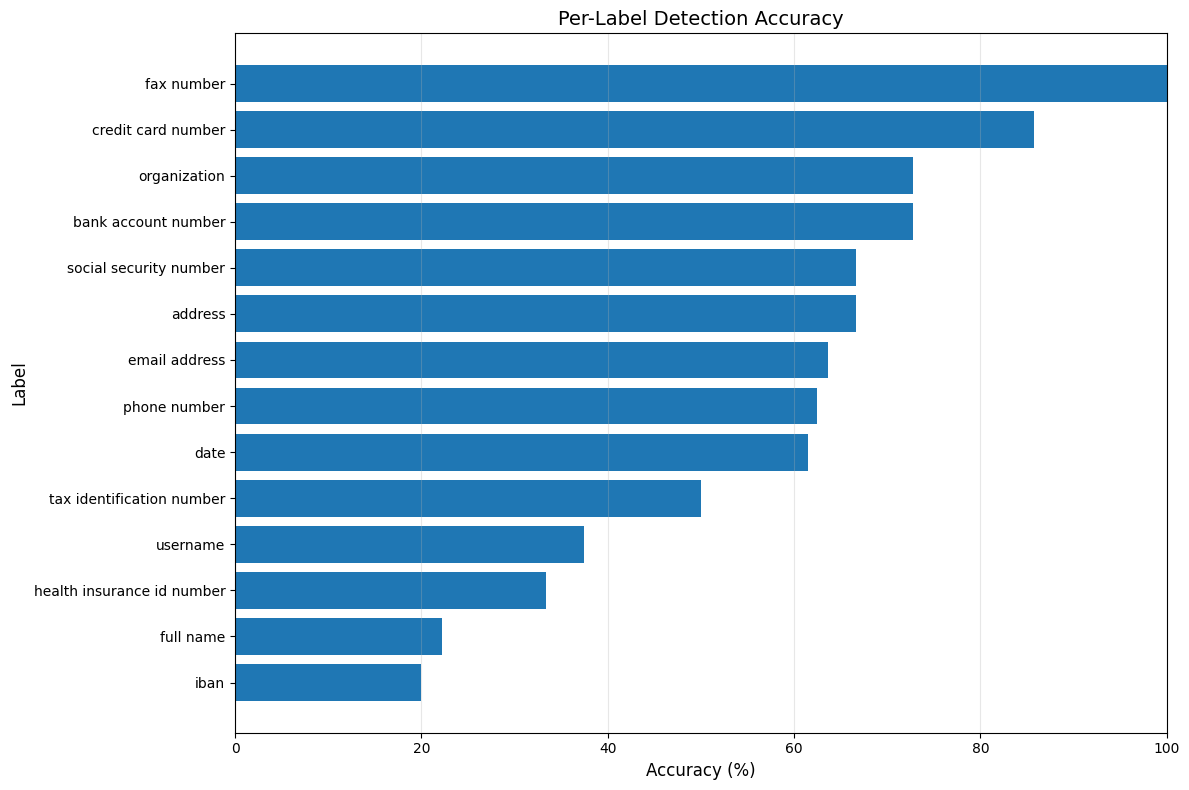

In [11]:
# Bar chart of accuracies
plt.figure(figsize=(12, 8))
plt.barh(accuracy_df['Label'], accuracy_df['Accuracy'])
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.title('Per-Label Detection Accuracy', fontsize=14)
plt.xlim(0, 100)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()